## Concrete Crack Images for Classification


In [2]:
# 1. CONFIGURACIÓN Y DESCARGA DE DATOS
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from google.colab import files
files.upload()

# Mover credenciales (ajusta si es necesario)
if not os.path.exists('/root/.kaggle'):
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# Descargar Dataset: Concrete Crack Images for Classification
# ID del dataset: arunrk7/surface-crack-detection (versión limpia del original de Ozgenel)
print("Descargando dataset...")
!kaggle datasets download -d arunrk7/surface-crack-detection

# Descomprimir
print("Descomprimiendo...")
with zipfile.ZipFile('surface-crack-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

print("Descarga completada")

Saving kaggle.json to kaggle (2).json
Descargando dataset...
Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Descomprimiendo...
Descarga completada


In [3]:
# 2. CARGA Y CREACIÓN DEL DATAFRAME

# Definir rutas
base_dir = Path('./data')
positive_dir = base_dir / 'Positive' # Grietas
negative_dir = base_dir / 'Negative' # Sin Grietas

# Generar lista de archivos
# Buscamos todas las imágenes .jpg
positive_images = list(positive_dir.glob('*.jpg'))
negative_images = list(negative_dir.glob('*.jpg'))

# Crear DataFrame
# Label 1 = Grieta (Positive), Label 0 = Sin Grieta (Negative)
images_df = pd.DataFrame({
    'filepath': [str(x) for x in positive_images] + [str(x) for x in negative_images],
    'label': [1] * len(positive_images) + [0] * len(negative_images)
})

# Mezclar datos (Shuffle)
images_df = images_df.sample(frac=1, random_state=42).reset_index(drop=True)

--- RESUMEN GLOBAL ---
Total de imágenes: 40000
Estructura del DataFrame:


,filepath,label
0,data/Negative/07100.jpg,0
1,data/Positive/14523_1.jpg,1
2,data/Negative/01904.jpg,0


/tmp/ipython-input-490194036.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=images_df, palette='coolwarm')


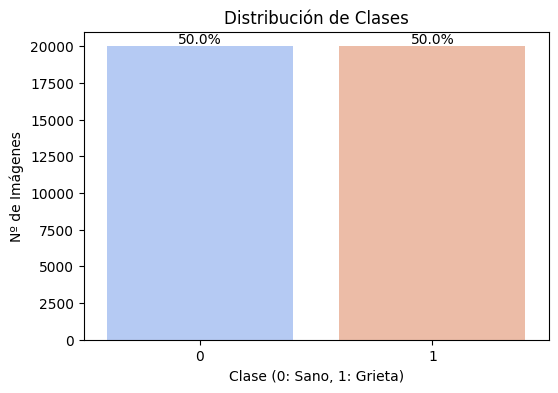


Analizando muestra representativa de 1000 imágenes...
> Dimensiones encontradas (WxH): {(227, 227)}
> Modo de color: RGB (3 canales RGB)
OK: Todas las imágenes tienen el mismo tamaño.


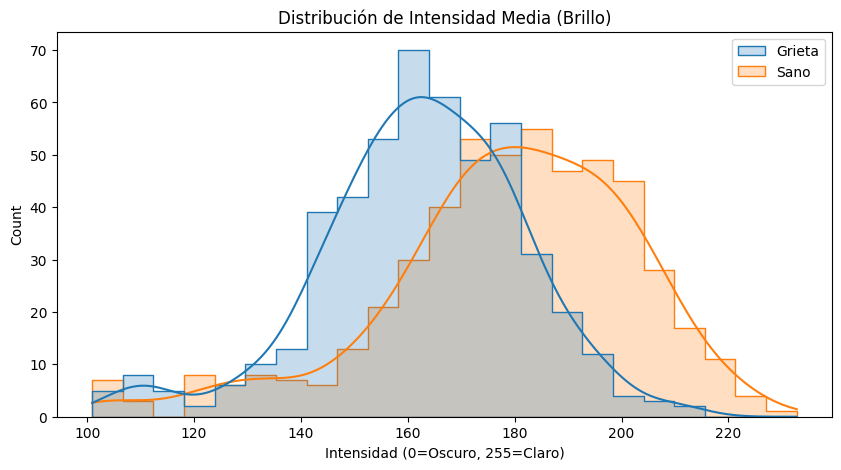

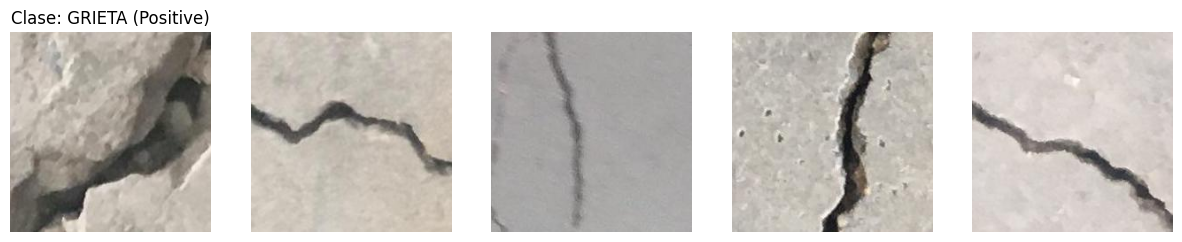

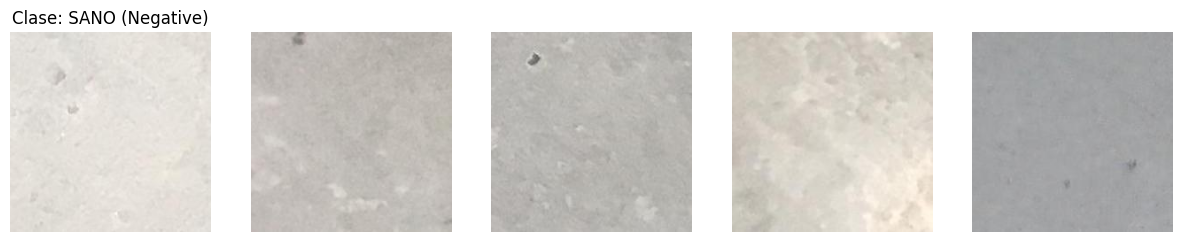

In [4]:
# 3. EDA (ANÁLISIS EXPLORATORIO DE DATOS)

print(f"--- RESUMEN GLOBAL ---")
print(f"Total de imágenes: {len(images_df)}")
print(f"Estructura del DataFrame:")
display(images_df.head(3))

# 3.1. Distribución de Clases (Balanceo)
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=images_df, palette='coolwarm')
plt.title('Distribución de Clases')
plt.xlabel('Clase (0: Sano, 1: Grieta)')
plt.ylabel('Nº de Imágenes')

# Anotación de porcentajes
total = len(images_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()

# 3.2. Calidad de Datos y Estadística de Píxeles

# Realizamos un muestreo para no saturar la RAM (1000 imágenes)
sample_size = 1000
print(f"\nAnalizando muestra representativa de {sample_size} imágenes...")

sample_df = images_df.sample(sample_size, random_state=42) # Volvemos a hace esto para quedarnos con 1000 imagenes aleatorias
shapes = []
intensities = []
labels_sample = []

# Bucle de extracción de características
for idx, row in sample_df.iterrows():
    img = Image.open(row['filepath'])
    img_arr = np.array(img)

    shapes.append(img.size)
    intensities.append(img_arr.mean()) # Brillo medio
    # Guardamos etiqueta como texto para mejor leyenda en el gráfico
    labels_sample.append('Grieta' if row['label'] == 1 else 'Sano')

# A) Verificación de Dimensiones y Canales
unique_shapes = set(shapes)
print(f"> Dimensiones encontradas (WxH): {unique_shapes}")
print(f"> Modo de color: {img.mode} (3 canales RGB)")

if len(unique_shapes) > 1:
    print("ALERTA: Imágenes de distintos tamaños detectadas.")
else:
    print("OK: Todas las imágenes tienen el mismo tamaño.")

# B) Histograma de Intensidad
plt.figure(figsize=(10, 5))
sns.histplot(x=intensities, hue=labels_sample, kde=True, element="step", common_norm=False)
plt.title('Distribución de Intensidad Media (Brillo)')
plt.xlabel('Intensidad (0=Oscuro, 255=Claro)')
plt.show()

# 3.3. Visualización de Ejemplos Reales
def plot_samples(df, label, class_name):
    subset = df[df['label'] == label].sample(5, random_state=42)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i, (_, row) in enumerate(subset.iterrows()):
        img = Image.open(row['filepath'])
        axes[i].imshow(img)
        axes[i].axis('off')
        if i == 0: axes[i].set_title(f"Clase: {class_name}")

    plt.show()

plot_samples(images_df, 1, "GRIETA (Positive)")
plot_samples(images_df, 0, "SANO (Negative)")

In [5]:
# 4. PREPARACIÓN DE X e y

# Por problemas de RAM solo guardamos el directorio y más adelante con una función 'ImageDataGenerator'
# iremos leyendo por lotes las imagenes para que no ocupe tanto espacio de RAM.

# Además, las dimensiones originales son 227 x 227 pero lo vamos a leer en 120x10 para que ocupe menos,
# Al utilizar un modelo complejo si que usaremos 224x224 ya que es lo que se exige por estandar.

# 1. Variables principales
X_paths = images_df['filepath'].values
y = images_df['label'].values

print(f"\n--- VARIABLES FINALES ---")
print(f"X (Rutas): {X_paths.shape}")
print(f"y (Etiquetas): {y.shape}")

# 2. Ejemplo de carga (X como tensores)
def load_batch_images(paths, size=(120, 120)):
    images = []
    for path in paths[:100]: # Solo cargamos 100 para probar
        img = Image.open(path).resize(size)
        images.append(np.array(img) / 255.0) # Normalización
    return np.array(images)

X_sample = load_batch_images(X_paths)

print(f"X_sample (Tensor de muestra 100 imgs): {X_sample.shape}")
print("Min valor pixel:", X_sample.min(), "Max valor pixel:", X_sample.max())

# Verificación
assert len(X_paths) == len(y), "Error: X e y no tienen el mismo tamaño"


--- VARIABLES FINALES ---
X (Rutas): (40000,)
y (Etiquetas): (40000,)
X_sample (Tensor de muestra 100 imgs): (100, 120, 120, 3)
Min valor pixel: 0.011764705882352941 Max valor pixel: 1.0
